# Web Scraping Project
- Done by: Navneet Mann
- Date: 2/8/2021

### TASK
-	Go to the link: https://store.steampowered.com/games/
-	You need to scrape the details of top 5 “New & Trending” Game details.
-	You need to research how the webscraping is done and then start doing the project.


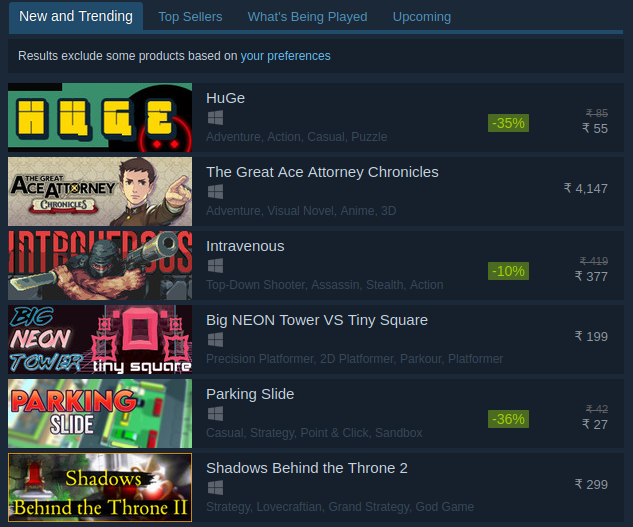

For every game, find out the number of positive reviews and name of developer and    publisher

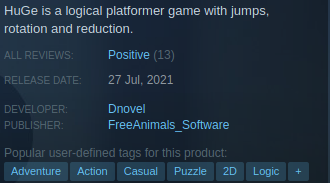

Find out the system requirements (minimum)

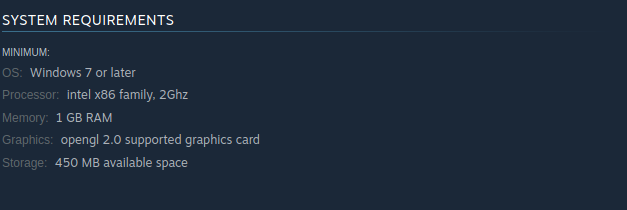

And 10 reviews for each game

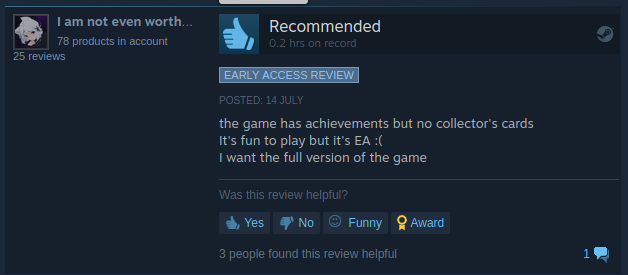

REQUIREMENT

For top 5 "New and Trending" games get:
- number of positive reviews
- name of developer
- publisher
- system requirements
- 10 reviews for each game

In [1]:
#let's install required library
!pip install requests-html

In [2]:
# for web scraping
from bs4 import BeautifulSoup
import requests
import urllib
import lxml.html

# for endering HTMLs
from requests_html import HTMLSession

# for handling json files and regex in python
import json
import re

# for dumping in csv
import pandas as pd

In [3]:
#CONSTANTS

STEAM_GAME_CATEGORY = 998
HEADERS = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:80.0) Gecko/20100101 Firefox/80.0'}
CLEAN_DICT = { "<li>": "", "</li>": "", "<strong>":"", "</strong>":"", "<br/>":""}

# Site urls
STEAM_URL = "https://store.steampowered.com/games/"
SEARCH_GAME_ID_URL = f"https://store.steampowered.com/search/?term='game_title'&category1={STEAM_GAME_CATEGORY}"
STEAM_GAME_PAGE = "https://store.steampowered.com/app/app_id"
STEAM_GAME_REVIEW = "https://store.steampowered.com/appreviews/app_id?json=1"

NUMBER_OF_GAMES = 5 # keep it less than 15
MAX_REVIEWS = 10 # number of reviews required for each game


In [4]:
# HTML names for scraping

# For game titles
GAME_TITLE_DIV = "NewReleasesRows"
GAME_TITLE_CLASS = "tab_item_name"

# For game ids
GAME_ID_DIV = "tab_item "
GAME_ID_CLASS = "data-ds-appid"

GAME_DEV = "developers_list"
GAME_SYS_REQ = "bb_ul"

# For game reviews
GAME_REVIEW_KEY1 = "query_summary"
GAME_REVIEW_KEY2 = "total_positive"
GAME_REVIEW_KEY3 = "reviews"
GAME_REVIEW_KEY4 = "review"


In [5]:
def get_rendered_html(page):
  """
  Fetch rendered html page
  """

  session = HTMLSession()

  try:
    r = session.get(page)

    if r.status_code == 200:
      return r

      #Inner utility function
      def get_first(result):
        if len(result) == 0:
          return None
        else:
          return result[0]

    else:
      print(f"Failed to fetch page: {page} with status code {r.status_code}")

  except:
    print(f"Failed to fetch page: {page}")
    return None


In [6]:
def get_game_from_steam(steam_url, games_to_fetch, headers=HEADERS):
  """
  Fetch the game titles and game Id from the New and trending tab from steam site
  """

  if games_to_fetch > 15:
    print("Please keep number of games less than 15")
    return

  resp = get_rendered_html(steam_url)
  soup = BeautifulSoup(resp.text, "html.parser")
  # print(soup.prettify())

  # get game titles
  print("Fetching all game titles")
  doc = lxml.html.fromstring(resp.content)
  new_trending = doc.xpath(f"//div[@id='{GAME_TITLE_DIV}']")[0]  
  titles = new_trending.xpath(f".//div[@class='{GAME_TITLE_CLASS}']/text()")
  # print(titles)

  # get game Ids
  print("Fetching all game Ids")
  game_ids = []
  for link in soup.find_all("a", class_=f"{GAME_ID_DIV}"):
    game_id = link.get(f"{GAME_ID_CLASS}")
    game_ids.append(game_id)
  # print(game_ids)

  game_dic = {}
  count = 0
  while count <= games_to_fetch:
    game_dic[game_ids[count]] = f"{titles[count]}"
    count += 1

  # print(game_dic)
  return game_dic


In [7]:
def get_game_reviews(app_id, steam_game_review, headers=HEADERS, max_reviews=MAX_REVIEWS):
  """
  Details about number of positive reviews and review content
  """
  
  steam_game_review = steam_game_review.replace("app_id", str(app_id))

  print(f"Fetching review json")
  resp_json = requests.get(steam_game_review, headers).text
  # print(resp_json)

  print(f"Getting number of positive reviews")
  rj = json.loads(resp_json)
  positive_reviews = rj[f"{GAME_REVIEW_KEY1}"][f"{GAME_REVIEW_KEY2}"]
  print(f"Number of positive revies: {positive_reviews}")

  print(f"Getting review contents")
  list_reviews = []
  for rev in rj[f"{GAME_REVIEW_KEY3}"]:
    if max_reviews > 0:
      list_reviews.append(rev[f"{GAME_REVIEW_KEY4}"])
      max_reviews -= 1
    else:
      break

  print(f"List of reviews --> {list_reviews}")

  return [positive_reviews, list_reviews]


In [8]:
def get_devs(soup):
  """
  Fetch devs of the game
  """

  print(f"Getting developers")
  dev_soup = soup.find(id = f"{GAME_DEV}")
  devs = []
  if dev_soup == None or len(dev_soup) == 0:
    devs = None
    print(f"Error: Problem with fetching developers for {game_id}")

  else:
    for link in dev_soup.find_all('a'):
      contents = link.text
      devs.append(contents)
    print(f"List of devs {devs}")

  return devs


In [9]:
def get_publishers(soup):
  """
  Fetch publisher of the game
  """

  print(f"Getting publisher")
  pub_soup = soup.find_all('a', {'href': re.compile(r'publisher')})
  if pub_soup == None or len(pub_soup) == 0:
    publisher = None
    print(f"Error: Problem with fetching publisher for {game_id}")
  else:

    for link in pub_soup:
      publisher = link.text
    print(f"Publisher: {publisher}")

  return publisher


In [10]:
def get_sys_req(soup, clean_dic=CLEAN_DICT):
  """
  Fetch minimum system requirments for the game
  """

  sys_req = []
  print(f"Getting system requirments")
  soup_sys = soup.find(class_=f"{GAME_SYS_REQ}")
  if soup_sys == None or len(soup_sys) == 0:
    sys_req = None
    print(f"Error: Problem with fetching system requirments for {game_id}")
  
  else:
    # get system_requirments
    for link in soup_sys:
      link = str(link)
      for x,y in clean_dic.items():
        link = link.replace(x, y)
      sys_req.append(link)
    print(f"System requirments {sys_req}")

  return sys_req

In [11]:
def get_game_details(app_id, steam_game_page, headers=HEADERS):
  """
  Get game details like developer, publisher, reviews for the particular game Id
  """

  steam_game_page = steam_game_page.replace("app_id", str(app_id))
  resp = get_rendered_html(steam_game_page)
  soup = BeautifulSoup(resp.text, "html.parser")

  # get devs
  devs = get_devs(soup)

  # get publisher
  publisher = get_publishers(soup)

  # set sys req
  sys_req = get_sys_req(soup, CLEAN_DICT)

  # get review number and content
  num_of_postive_reviews, reviews = get_game_reviews(app_id, STEAM_GAME_REVIEW, HEADERS)

  return [devs, publisher, num_of_postive_reviews, sys_req, reviews]


In [12]:
df = pd.DataFrame(columns=["Title", "Developer", "Publisher", "Number of Postive Reviews", "System Requirements", "Review"])

In [13]:
# Driver code

# Get basic info for new and trending games
game_dic = get_game_from_steam(STEAM_URL, NUMBER_OF_GAMES, HEADERS)

for game_id, game_title in game_dic.items():

  print("#####################################################")
  print(f"game Id --> {game_id} game title --> {game_title}")
  
  if game_id == None:
    print(f"Error: Problem with fetching game id for {game_title}")
    continue

  developer, publisher, num_of_postive_reviews, system_req, reviews = get_game_details(game_id, STEAM_GAME_PAGE, HEADERS)
  print("#####################################################")

  df.loc[len(df.index)] = [game_title, developer, publisher, num_of_postive_reviews, system_req, reviews] 


Fetching all game titles
Fetching all game Ids
#####################################################
game Id --> 1061100 game title --> Hunter's Arena: Legends
Getting developers
List of devs ['Mantisco']
Getting publisher
Publisher: Mantisco
Getting system requirments
System requirments ['OS: 64-bit Windows 7, Windows 8.1, Windows 10', 'Processor: Intel Core i5-4430 / AMD FX-6300', 'Memory: 8 GB RAM', 'Graphics: NVIDIA GeForce GTX 770 / AMD Radeon R7 370 2GB', 'DirectX: Version 11', 'Network: Broadband Internet connection', 'Storage: 30 GB available space']
Fetching review json
Getting number of positive reviews
Number of positive revies: 187
Getting review contents
List of reviews --> ['Good Games Yes Yes']
#####################################################
#####################################################
game Id --> 985650 game title --> Olaguna Chronicles
Getting developers
List of devs ['SELeft Studio']
Getting publisher
Publisher: Lycian Studio
Getting system requirments


In [14]:
df.head(15)

,Title,Developer,Publisher,Number of Postive Reviews,System Requirements,Review
0,Hunter's Arena: Legends,[Mantisco],Mantisco,187,"[OS: 64-bit Windows 7, Windows 8.1, Windows 10...",[Good Games Yes Yes]
1,Olaguna Chronicles,[SELeft Studio],Lycian Studio,0,"[OS: WIN7/WIN10, Processor: Pentium Dual Core级...",[]
2,Who Stole My Beard?,[Cleardot Games],Cleardot Games,9,"[OS: 7, Processor: Intel 3 or higher, Memory: ...",[Fun game with great artwork and bubbly music ...
3,Creatures of Aether,"[Tako Boy Studios, Dan Fornace]",Dan Fornace,0,"[OS: Windows 7 / 8 / 10, Processor: 2.0 Ghz, M...",[]
4,GRIME,[Clover Bite],Akupara Games,56,"[OS: Windows 7, Processor: Intel i5 3470 or AM...",[I remember when the word Metroidvania actuall...
5,Big Farm Story,[Goodgame Studios],Goodgame Studios,87,[Requires a 64-bit processor and operating sys...,[This is an amusing farming sim game. There is...


In [15]:
# save in csv format
df.to_csv("game_details.csv")

References:
- https://timber.io/blog/an-intro-to-web-scraping-with-lxml-and-python/
- https://stackoverflow.com/questions/8049520/web-scraping-javascript-page-with-python
- https://colab.research.google.com/github/hamletbatista/sej/blob/master/Hands_on_Introduction_to_Machine_Learning_for_SEOs.ipynb#scrollTo=PqnmoSi2QA-x

- https://andrew-muller.medium.com/scraping-steam-user-reviews-9a43f9e38c92
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/
- http://akul.me/blog/2016/beautifulsoup-cheatsheet/
- https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list